In [1]:
%load_ext autoreload
%autoreload 2
data_folder= "/data6/wuyinjun/image_causal_data/uganda/uganda/"
from image_loader import CausalDataset

c_dataset = CausalDataset(data_folder)

/data6/wuyinjun/pyenv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data6/wuyinjun/image_causal_data/uganda/uganda/UgandaGeoKeyMat.csv


In [2]:
print(list(c_dataset[330].keys()))

['band1', 'img_metadata', 'band2', 'band3', 'Unnamed: 0', 'MERGE_ID', 'P_02_ID', 'geo_long_center', 'geo_lat_center', 'PNAME_VALUE', 'SNAME_2002', 'geolocated_failed', 'dist_geolocation', 'geo_long', 'geo_lat', 'key']


In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage import io, color, segmentation
from skimage import io, color, segmentation, measure

from transformers import CLIPProcessor, CLIPModel
import torch
from tqdm import tqdm


# image_id=50
def get_segments_and_embeddings_for_all_images():
    outputs_ls=[]
    all_regions_ls=[]
    all_image_ids = []
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    for image_id in tqdm(range(331)):
        array_3d = np.stack([c_dataset[image_id]['band1'], c_dataset[image_id]['band2'], c_dataset[image_id]['band3']], axis=-1).astype(np.uint8)
        c_dataset[image_id]['band1']
        image = Image.fromarray(array_3d)
        lab_image = color.rgb2lab(image)

        segments_slic = slic(lab_image, n_segments=20, compactness=200, max_num_iter=200)
        # print(np.unique(segments_slic))
        regions = measure.regionprops(segments_slic)
        for patch_id in range(len(regions)):
            x,y,w,h = regions[patch_id].bbox[0], regions[patch_id].bbox[1], regions[patch_id].bbox[2], regions[patch_id].bbox[3]
            patch = Image.fromarray(array_3d[x:w, y:h])
            inputs = processor(images=patch, return_tensors="pt", padding=False)
            inputs.to(device)
            with torch.no_grad():
                outputs = model.get_image_features(**inputs)
                outputs_ls.append(outputs)
                all_image_ids.append(image_id)
        all_regions_ls.extend(regions)
    return outputs_ls, all_regions_ls, all_image_ids

outputs_embedding_ls, all_regions_ls, all_image_ids = get_segments_and_embeddings_for_all_images()
print(len(outputs_embedding_ls))

In [ ]:
outputs_tensor = torch.cat(outputs_embedding_ls)
outputs_tensor = outputs_tensor/torch.norm(outputs_tensor, dim=1, keepdim=True)


from featurization import k_means
centroids, cluster_assignments = k_means(outputs_tensor, 20)


 59%|█████▉    | 59/100 [00:00<00:00, 384.38it/s]


In [ ]:
dist = torch.cdist(outputs_tensor, centroids)
closest_centroid_sample_idx = dist.argmin(dim=0)
print(closest_centroid_sample_idx)
print(len(all_regions_ls))

tensor([3396, 1328, 1620, 1938, 5023, 1960, 5060,  381, 4109, 1184,  510, 1944,
        2029, 1143, 4339, 3058,  523, 2026, 1706, 3172], device='cuda:0')
5296


In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
patch_ls = []
full_image_ls = []
for idx, patch_id in enumerate(closest_centroid_sample_idx.tolist()):
    x,y,w,h = all_regions_ls[patch_id].bbox[0], all_regions_ls[patch_id].bbox[1], all_regions_ls[patch_id].bbox[2], all_regions_ls[patch_id].bbox[3]
    print(x,y,w,h)
    image_id = all_image_ids[patch_id]
    array_3d = np.stack([c_dataset[image_id]['band1'], c_dataset[image_id]['band2'], c_dataset[image_id]['band3']], axis=-1).astype(np.uint8)
    patch_array = array_3d[x:w, y:h]
    patch = Image.fromarray(patch_array)
    # image = color.rgb2gray(patch)
    image_resized = resize(patch_array, (64,64))
    patch_ls.append(patch)
    full_image_ls.append(array_3d)
    
    # plt.subplot(len(closest_centroid_sample_idx),1,idx+1)
    # plt.imshow(image_resized)

77 75 184 163


0 0 91 94
77 77 166 188
0 165 78 265
260 260 351 351
163 167 255 270
78 81 162 187
254 169 351 261
254 170 351 260
0 0 95 91
260 0 351 91
161 165 254 270
261 0 351 91
84 0 179 98
0 260 93 351
0 181 97 268
172 252 268 351
182 255 268 351
168 162 272 254
77 165 163 270


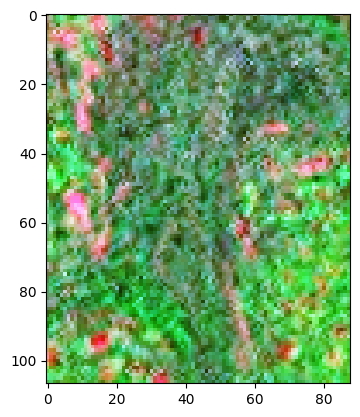

In [ ]:
plt.imshow(patch_ls[0])

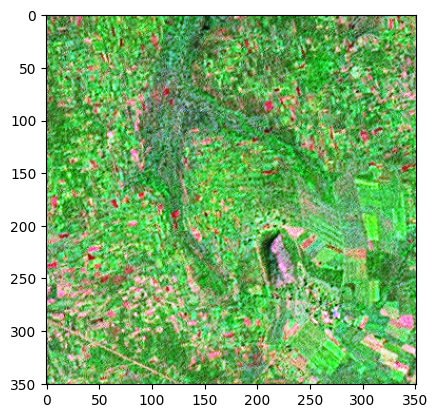

In [ ]:
plt.imshow(Image.fromarray(full_image_ls[0].astype(np.uint8)))

In [4]:
import os, pickle
data_folder = "/data6/wuyinjun/image_causal_data/uganda/"
image_id_to_patch_id_file_name = os.path.join(data_folder, "image_id_to_patch_ids")
real_image_array_file = os.path.join(data_folder, "real_test_images")
with open(real_image_array_file, "rb") as f:
    read_image_array = pickle.load(f)

with open(image_id_to_patch_id_file_name, "rb") as f:
    image_id_to_patch_ids = pickle.load(f)

image_to_unique_image_idx_file_name = os.path.join(data_folder, "image_to_unique_image_idx.pkl")
with open(image_to_unique_image_idx_file_name, "rb") as f:
        image_to_unique_image_idx = pickle.load(f)



In [ ]:
len(read_image_array)

415

In [5]:
real_image_array_file = os.path.join(data_folder, "real_train_images")
with open(real_image_array_file, "rb") as f:
    train_image_array = pickle.load(f)

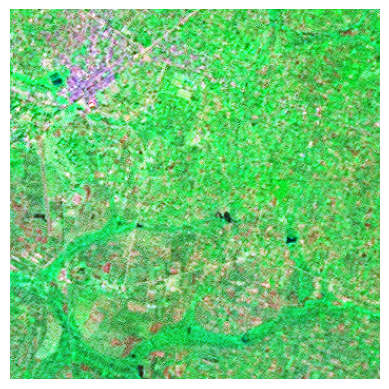

In [ ]:
from PIL import Image
import numpy as np

target_image = Image.fromarray(train_image_array[898].astype(np.uint8))
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis
ax.imshow(target_image)
plt.show()


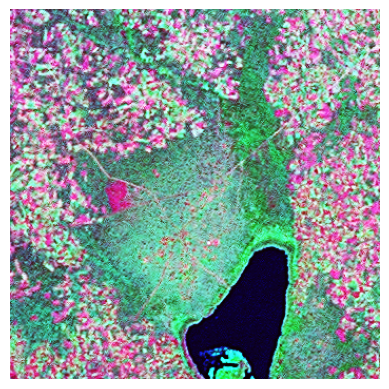

In [ ]:
from PIL import Image
import numpy as np

target_image = Image.fromarray(read_image_array[86].astype(np.uint8))
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis
ax.imshow(target_image)
plt.show()


In [6]:
import os
import pickle
data_folder = "/data6/wuyinjun/image_causal_data/uganda/"
patch_ls_file = os.path.join(data_folder, "patch_ls")
patch_full_image_ls = os.path.join(data_folder, "patch_full_image_ls")


with open(patch_ls_file, "rb") as f:
    patch_ls = pickle.load(f)
with open(patch_full_image_ls, "rb") as f:
    full_image_ls = pickle.load(f)

In [7]:
len(patch_ls)

20

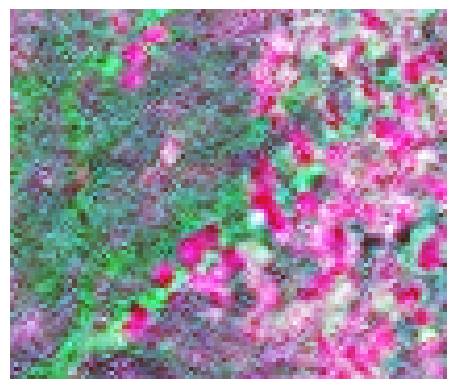

In [10]:
patch_id =10
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis
ax.imshow(patch_ls[patch_id])
plt.show()

/data6/wuyinjun/pyenv2/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  import sys


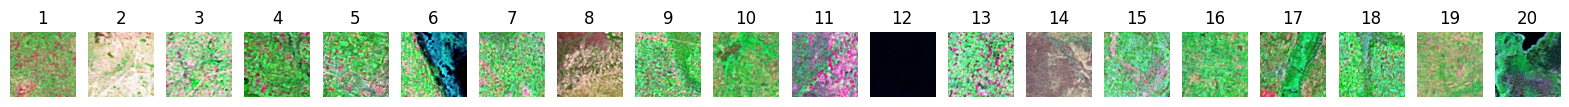

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
fig, ax = plt.subplots(1, len(patch_ls), figsize=(20, 6))  # Adjust the figsize as needed
for i, image_path in enumerate(patch_ls):
    # img = mpimg.imread(image_path)
    img = patch_ls[i].resize((200, 200), Image.ANTIALIAS)
    ax[i].imshow(img)
    ax[i].axis('off')  # Hide axis
    ax[i].set_title(f"{i+1}")

# plt.show()
plt.savefig("concepts.svg", format="svg", dpi=300, bbox_inches='tight')
# patch_id = 0
# fig, ax = plt.subplots()
# ax.axis('off')  # Turn off the axis
# ax.imshow(patch_ls[patch_id])
# plt.show()

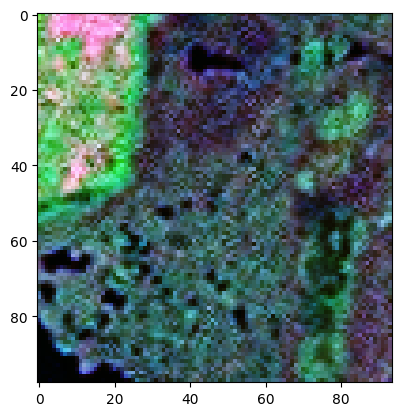

In [ ]:
patch_id = 9
plt.imshow(patch_ls[patch_id])

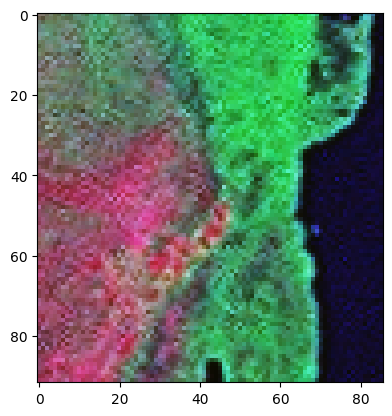

In [ ]:
patch_id = 2
plt.imshow(patch_ls[patch_id])

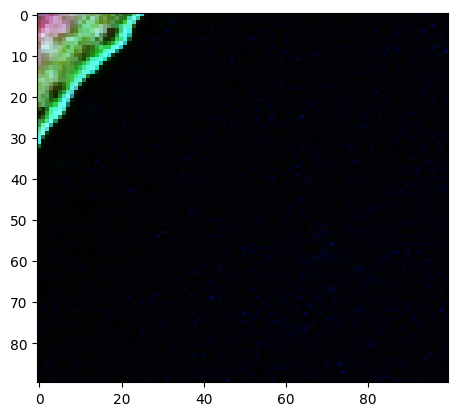

In [ ]:
patch_id = 3
plt.imshow(patch_ls[patch_id])

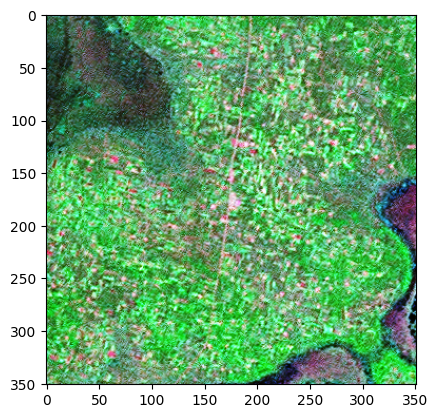

In [ ]:
plt.imshow(full_image_ls[patch_id])

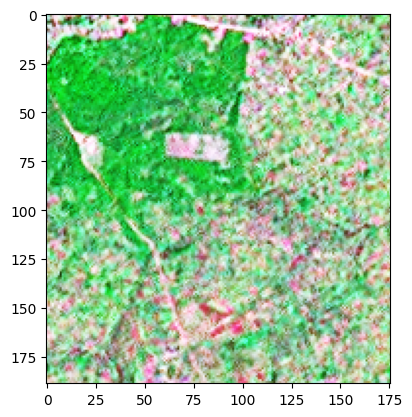

In [ ]:
# patch_id=9
# x,y,w,h = regions[patch_id].bbox[0], regions[patch_id].bbox[1], regions[patch_id].bbox[2], regions[patch_id].bbox[3]
# plt.imshow(Image.fromarray(array_3d[x:x+w, y:y+h]))

In [ ]:
outputs_tensor = torch.cat(outputs_ls, dim=0)
print(outputs_tensor.shape)

outputs_tensor = outputs_tensor/torch.norm(outputs_tensor, dim=1, keepdim=True)




torch.Size([16, 512])


  1%|          | 1/100 [00:00<00:00, 398.58it/s]


In [ ]:
print(cluster_assignments)

tensor([2, 2, 4, 2, 3, 4, 4, 4, 0, 4, 4, 2, 4, 4, 1, 2], device='cuda:0')


In [ ]:
print(outputs_tensor.shape)
print(centroids.shape)

torch.Size([16, 512])
torch.Size([5, 512])
